## Описание данных

Будем работать с данными `covtype.data` о типе лесного покрытия из репозитория UCI. Доступно 7 различных классов:

| ![cover_type1.jpg](ml_lab0/img/cover_type1.jpg) | ![cover_type2.jpg](img/cover_type2.jpg)|![cover_type3.jpg](img/cover_type3.jpg) | ![cover_type4.jpg](img/cover_type4.jpg)| ![cover_type5.jpg](img/cover_type5.jpg)| ![cover_type6.jpg](img/cover_type6.jpg)| ![cover_type7.jpg](img/cover_type7.jpg)|
|:--:|:--:|:--:|:--:|:--:|:--:|:--:|
| *1. Spruce/Fir* | *2. Lodgepole Pine* |*3. Ponderosa Pine* | *4. Cottonwood/Willow* | *5. Aspen* |*6. Douglas-fir* | *7. Krummholz* |

Каждый объект описывается 54 признаками. Описание данных доступно в файле `covtype.info`. 

Поставим задачу классификации - определить тип лесного покрова. 

Скачать данные: http://archive.ics.uci.edu/ml/datasets/Covertype

## Анализ данных

Для начала импортируем все нужные библиотеки

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

Начнем с самой важной части - посмотрим на данные. Приведем названия колонок в презентабельный вид в соответсвии с информационным файлом, загрузим их и посмотрим на небольшую часть.

И заодно разделим признаки на числовые и категориальные, а также выделим целевой признак

In [2]:
num_cols = [
    'Elevation',
    'Aspect',
    'Slope',
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Hillshade_9am',
    'Hillshade_Noon',
    'Hillshade_3pm',
    'Horizontal_Distance_To_Fire_Points',
]

cat_cols = []

cnt = 1
for i in range(10, 14):
    cat_cols.append( f'Wilderness_Area{cnt}')
    cnt+=1

cnt = 1
for i in range(14, 54):
    cat_cols.append(f'Soil_Type{cnt}')
    cnt+=1

feature_cols = num_cols + cat_cols

target_col = 'Cover_Type'

cols = feature_cols + [target_col]

covtype_data = pd.read_csv("covtype.data", 
                  sep=',', 
                  names=cols)

print("Размерность датасета:", covtype_data.shape)
covtype_data.head()

Размерность датасета: (581012, 55)


Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0       2596      51      3                               258   
1       2590      56      2                               212   
2       2804     139      9                               268   
3       2785     155     18                               242   
4       2595      45      2                               153   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   
4                              -1                              391   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
0            221             232            148   
1            220             235            151   
2            234             238            135   
3            238             238            122   
4            220             234            150   

   Horizontal_Distance_To_Fire_Points  ...  Soil_Type32  Soil_Type33  \
0                                6279  ...            0            0   
1                                6225  ...            0            0   
2                                6121  ...            0            0   
3                                6211  ...            0            0   
4                                6172  ...            0            0   

   Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  Soil_Type38  \
0            0            0            0            0            0   
1            0            0            0            0            0   
2            0            0            0            0            0   
3            0            0            0            0            0   
4            0            0            0            0            0   

   Soil_Type39  Soil_Type40  Cover_Type  
0            0            0           5  
1            0            0           5  
2            0            0           2  
3            0            0           2  
4            0            0           5  

[5 rows x 55 columns]

## Разделение на train/validation/test

Заранее разделим наши данные на тестовую, валидационную и тренировочную выборки, чтобы не допустить утечек. В информационном файле сказано следующее:

		-- first 11,340 records used for training data subset
		-- next 3,780 records used for validation data subset
		-- last 565,892 records used for testing data subset

In [3]:
X_train = covtype_data[feature_cols][0:11340]
y_train = covtype_data[target_col][0:11340]

X_valid = covtype_data[feature_cols][11340:15120]
y_valid = covtype_data[target_col][11340:15120]

X_test = covtype_data[feature_cols][15120:581012]
y_test = covtype_data[target_col][15120:581012]

print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(11340, 54) (11340,)
(3780, 54) (3780,)
(565892, 54) (565892,)


Далее будем работать с тренировочной выборкой, а затем полученные преобразования признаков применим к валидационным и тестовым данным

In [4]:
data = X_train.assign(Cover_Type=y_train.values)
data.shape

(11340, 55)

Посмотрим на типы данных и количество ненулевых строк

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11340 entries, 0 to 11339
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   Elevation                           11340 non-null  int64
 1   Aspect                              11340 non-null  int64
 2   Slope                               11340 non-null  int64
 3   Horizontal_Distance_To_Hydrology    11340 non-null  int64
 4   Vertical_Distance_To_Hydrology      11340 non-null  int64
 5   Horizontal_Distance_To_Roadways     11340 non-null  int64
 6   Hillshade_9am                       11340 non-null  int64
 7   Hillshade_Noon                      11340 non-null  int64
 8   Hillshade_3pm                       11340 non-null  int64
 9   Horizontal_Distance_To_Fire_Points  11340 non-null  int64
 10  Wilderness_Area1                    11340 non-null  int64
 11  Wilderness_Area2                    11340 non-null  int64
 12  Wild

Теперь посмотрим на основные статистические данные, котрые можно получить сразу же

In [6]:
data.describe()

Elevation        Aspect         Slope  \
count  11340.000000  11340.000000  11340.000000   
mean    2750.021076    156.569841     16.499559   
std      417.376392    110.200187      8.472961   
min     1863.000000      0.000000      0.000000   
25%     2376.000000     64.000000     10.000000   
50%     2752.000000    126.000000     15.000000   
75%     3107.000000    261.000000     22.000000   
max     3849.000000    360.000000     52.000000   

       Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology  \
count                      11340.000000                    11340.000000   
mean                         229.062257                       51.252646   
std                          210.222587                       61.228040   
min                            0.000000                     -146.000000   
25%                           67.000000                        5.000000   
50%                          180.000000                       33.000000   
75%                          330.000000                       80.000000   
max                         1343.000000                      554.000000   

       Horizontal_Distance_To_Roadways  Hillshade_9am  Hillshade_Noon  \
count                     11340.000000   11340.000000    11340.000000   
mean                       1711.778131     212.584392      218.978571   
std                        1325.834736      30.504781       22.909593   
min                           0.000000       0.000000       99.000000   
25%                         760.000000     196.000000      207.000000   
50%                        1308.000000     220.000000      222.000000   
75%                        2271.000000     235.000000      235.000000   
max                        6890.000000     254.000000      254.000000   

       Hillshade_3pm  Horizontal_Distance_To_Fire_Points  ...   Soil_Type32  \
count   11340.000000                        11340.000000  ...  11340.000000   
mean      135.243386                         1511.103527  ...      0.047090   
std        45.826363                         1100.502534  ...      0.211841   
min         0.000000                           30.000000  ...      0.000000   
25%       107.000000                          731.000000  ...      0.000000   
50%       138.000000                         1262.000000  ...      0.000000   
75%       167.000000                         1984.500000  ...      0.000000   
max       248.000000                         6853.000000  ...      1.000000   

        Soil_Type33   Soil_Type34   Soil_Type35   Soil_Type36   Soil_Type37  \
count  11340.000000  11340.000000  11340.000000  11340.000000  11340.000000   
mean       0.041534      0.001323      0.006614      0.000705      0.002116   
std        0.199531      0.036347      0.081059      0.026552      0.045958   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

        Soil_Type38   Soil_Type39   Soil_Type40    Cover_Type  
count  11340.000000  11340.000000  11340.000000  11340.000000  
mean       0.048148      0.044180      0.029189      4.000000  
std        0.214089      0.205504      0.168343      2.000088  
min        0.000000      0.000000      0.000000      1.000000  
25%        0.000000      0.000000      0.000000      2.000000  
50%        0.000000      0.000000      0.000000      4.000000  
75%        0.000000      0.000000      0.000000      6.000000  
max        1.000000      1.000000      1.000000      7.000000  

[8 rows x 55 columns]

Убедимся, что два категориальных признака `Wilderness_Area` и `Soil_Type` являются one-hot-encoded

In [7]:
is_binary_columns = [column for column in data.columns if ("Wilderness" in column) | ("Soil" in column)]
print(pd.unique(data[is_binary_columns].values.ravel()))

data["w_sum"] = data["Wilderness_Area1"] + data["Wilderness_Area2"] + data["Wilderness_Area3"] + data["Wilderness_Area4"]
print(data.w_sum.value_counts())

soil_columns = [c for c in data.columns if "Soil" in c]
data["soil_sum"] = 0

for c in soil_columns:
    data["soil_sum"] += data[c]

print(data.soil_sum.value_counts())

data.drop(columns=["w_sum", "soil_sum"], inplace=True)

[1 0]
1    11340
Name: w_sum, dtype: int64
1    11340
Name: soil_sum, dtype: int64


Наше предположение подтвердилось. Тогда приведем тип почвы к количественному значению, чтобы сильно уменьшить размерность наших признаков. Выделим это в отдельную функцию, чтобы применять в дальнейшем для остальных данных

In [8]:
def make_soil_type_num(data):  
    # create a list of soil_type columns
    soil_columns = [c for c in data.columns if "Soil" in c]

    soil_type = [None] * data['Soil_Type1'].size
    # sum of all soil type columns
    for c in soil_columns:
        i = 0
        for index in data[c]:
            if (index == 1):
                soil_type[i] = int(c[9:])
            i+=1

    data.drop(columns=soil_columns, inplace=True)
    data['Soil_Type'] = soil_type

Посмотрим на распредление числовых признаков

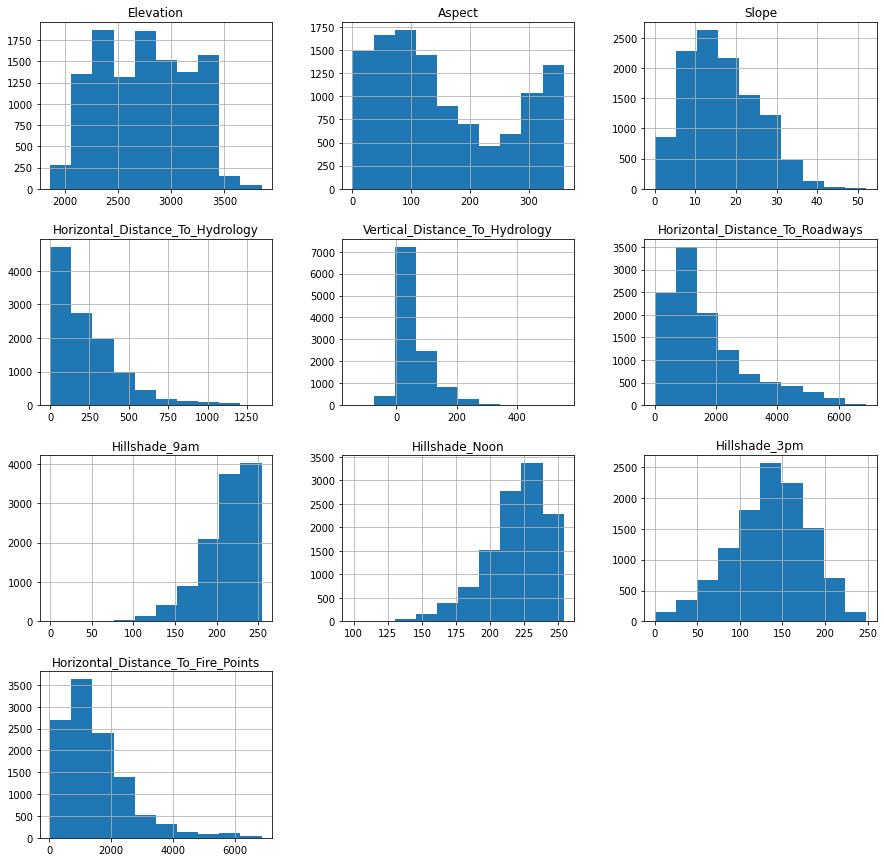

In [9]:
data.hist(column=num_cols, figsize=(15, 15));

Посмотрим на двойные графики

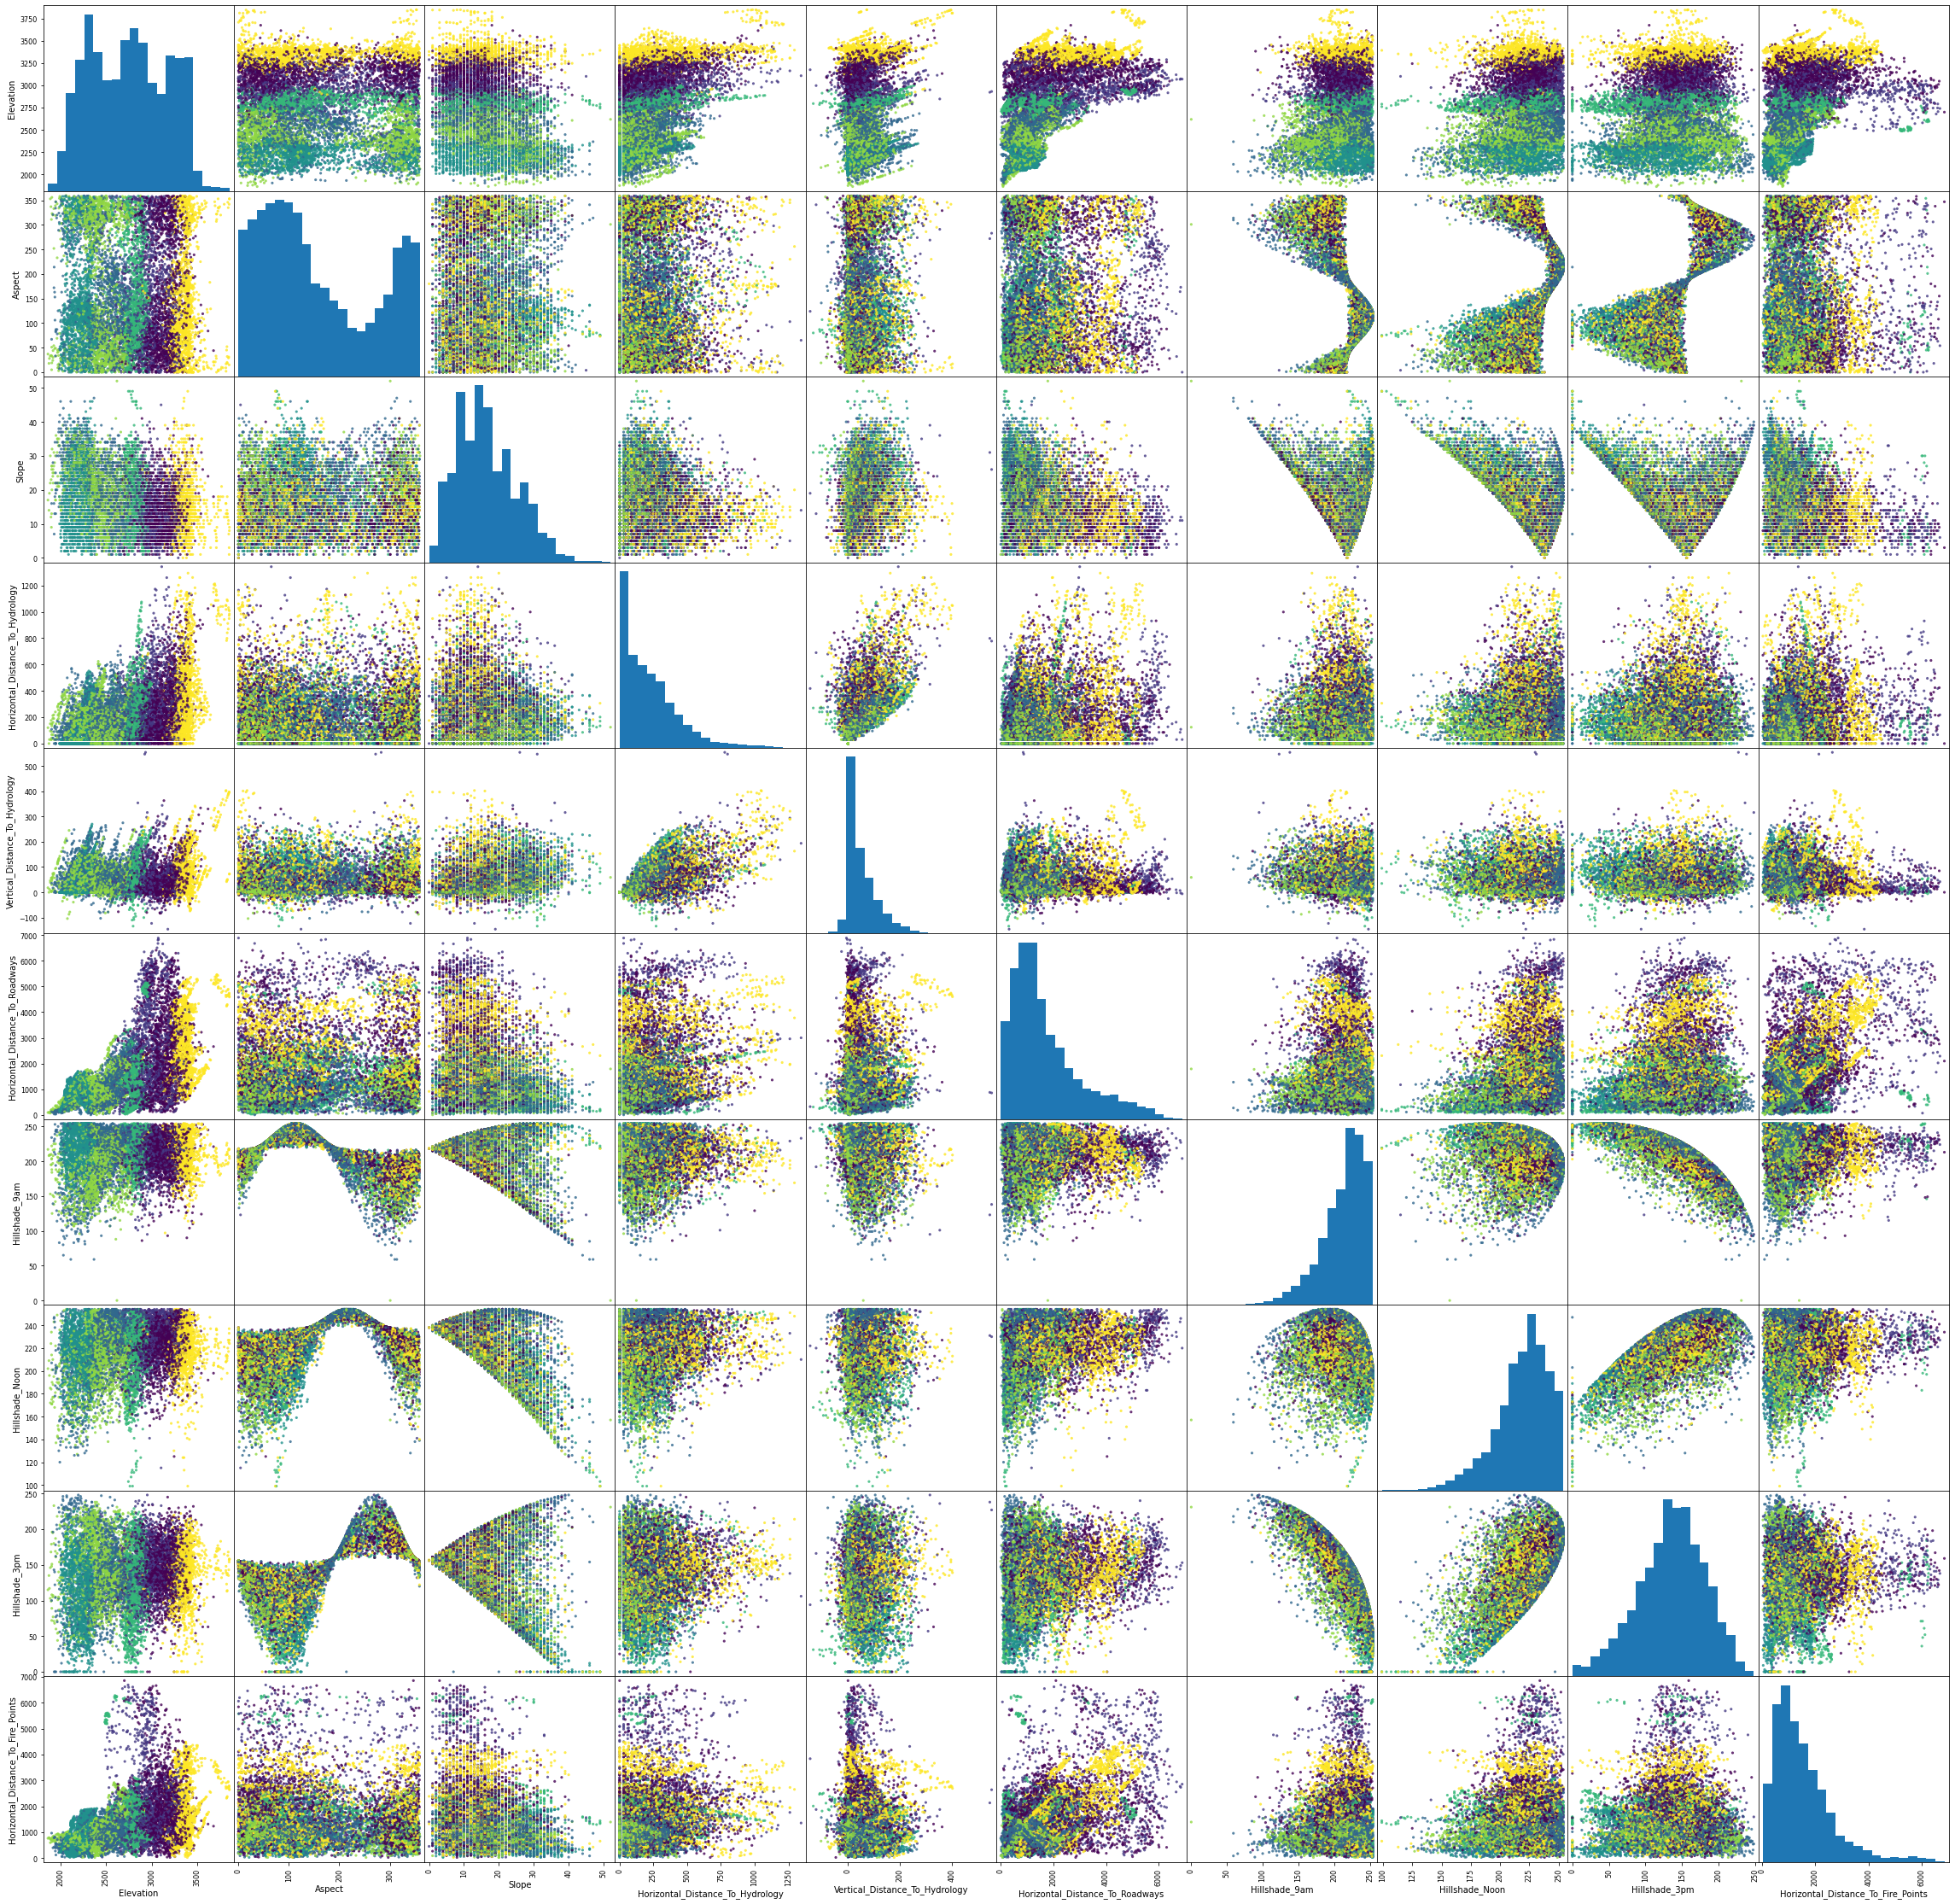

In [10]:
make_soil_type_num(data)
pd.plotting.scatter_matrix(data[num_cols], c=data[target_col], figsize=(40, 40), marker='o', hist_kwds={'bins': 20}, s=10, alpha=.8);

И на корреляции между признаками

In [11]:
data.corr().style.background_gradient(cmap='coolwarm').format(precision=2)

Можно заметить, что между всеми признаками `Hillshade` есть коллинеарность. Кроме того `Hillshade_9am` имеет самый низкий коэффициент Пирсона, равный *-0.01*, поэтому этот призак мы в дальнейшем исключим. 

К сожалению, вообще все признаки имеют довольно низкий коэффициент Пирсона для целевого столбца.

Посмотрим теперь на то, как связаны категориальные признаки

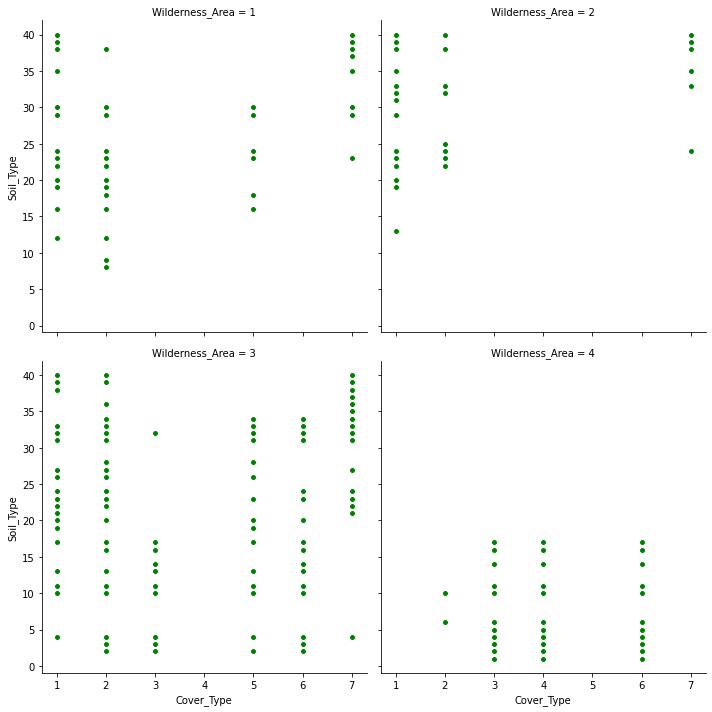

In [12]:
wilderness_columns = [c for c in data.columns if "Wilderness" in c]
wilderness_area = [None] * data['Wilderness_Area1'].size
for c in wilderness_columns:
    i = 0
    for index in data[c]:
        if (index == 1):
            wilderness_area[i] = int(c[15:])
        i+=1

data['Wilderness_Area'] = wilderness_area
wilderness_area_nums = sorted(data['Wilderness_Area'].value_counts().index.tolist())

sns.set_context(font_scale=2)
g = sns.FacetGrid(data, col="Wilderness_Area", col_wrap=2, height=5, col_order=wilderness_area_nums)
g = g.map(plt.scatter,"Cover_Type", "Soil_Type", edgecolor="w", color="g")

- Зона 3 содержит разнообразные типы почвы и покрытий
- Зона 4 cодержит только типы почвы с 1 по 20
- Покров 7 растет на типе почвы от 25 до 40
- Покровы 5 и 6 может расти на большинстве типов почвы
- Покров 3 часто растет на типе почвы от 0 до 15
- Покровы 1 и 2 может расти на любом типе почвы

Исходя из этого мы добавим несколько признаков, связывающих `Soil_Type` и `Wilderness_Area`

## Cоздание новых признаков

Для данного датасета можно применить некоторую обработку данных о растояниях и добавить в виде новых признаков их вариации, такие как евклидово расстояние для `Horizontal_Distance_To_Hydrology` и `Vertical_Distance_To_Hydrology` и среднее для всех остальных растояний. 

Для того, чтобы повысить корреляцию вычислим квадратный корень для всех признаков, помотрим на коэффициент Пирсона и там где он выше исходного, проведем замену признаков

In [13]:
for col in data.columns:
    if data[col].min() >= 0:
        if col == 'Cover_Type':
            next
        else:
            data['sqrt' + col] = np.sqrt(data[col])

correlations_transformed = pd.DataFrame(data.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["Cover_Type"]).reset_index()

correlations_transformed.columns = ["Feature", "Correlation with Cover_Type"]
correlations_transformed = (correlations_transformed[correlations_transformed["Feature"] != "Cover_Type"].sort_values(by="Correlation with Cover_Type", ascending=True))

Теперь соберем все наши наработки в одну единственную функцию преобразования и применим ее к тренирочному, валидационному и тестовому наборам признаков

In [14]:
def transform(data):
    # добавим числовой столбец типа почвы вместо one-hot-encoded
    make_soil_type_num(data)
    
    # добавим линейные комбинации столбцов расстояний
    data['Euclidian_Distance_To_Hydrology'] = (data['Horizontal_Distance_To_Hydrology']**2 + data['Vertical_Distance_To_Hydrology']**2)**0.5
    data['Mean_Elevation_Vertical_Distance_Hydrology'] = (data['Elevation'] + data['Vertical_Distance_To_Hydrology'])/2
    data['Mean_Distance_Hydrology_Firepoints'] = (data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Fire_Points'])/2
    data['Mean_Distance_Hydrology_Roadways'] = (data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways'])/2
    data['Mean_Distance_Firepoints_Roadways'] = (data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Roadways'])/2

    # добавим произведения категориальных признаков
    data['WA1_To_ST'] = (data['Wilderness_Area1'] * data['Soil_Type'])
    data['WA2_To_ST'] = (data['Wilderness_Area2'] * data['Soil_Type'])
    data['WA3_To_ST'] = (data['Wilderness_Area3'] * data['Soil_Type'])
    data['WA4_To_ST'] = (data['Wilderness_Area4'] * data['Soil_Type'])

    # заменим столбцы для которых корень показал лучшее значение
    data['sqrt' + 'Horizontal_Distance_To_Hydrology'] = np.sqrt(data['Horizontal_Distance_To_Hydrology'])
    data['sqrt' + 'Mean_Distance_Hydrology_Roadways'] = np.sqrt(data['Mean_Distance_Hydrology_Roadways'])
    data['sqrt' + 'Euclidian_Distance_To_Hydrology'] = np.sqrt(data['Euclidian_Distance_To_Hydrology'])

    # окончательный список признаков
    wilderness_areas = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4']
    transformed_features = ['WA1_To_ST', 'WA2_To_ST', 'WA3_To_ST', 'WA4_To_ST', 'sqrtHorizontal_Distance_To_Hydrology', 'sqrtMean_Distance_Hydrology_Roadways', 'sqrtEuclidian_Distance_To_Hydrology', 
                            'Mean_Elevation_Vertical_Distance_Hydrology', 'Mean_Distance_Firepoints_Roadways', 'Mean_Distance_Hydrology_Firepoints']

    all_features = (['Elevation', 'Aspect', 'Slope', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 
                    'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points' ] + wilderness_areas +
                    ['Soil_Type'] + transformed_features)
    data = data[all_features]

In [15]:
transform(X_train)
transform(X_valid)
transform(X_test)

## Масштабирование признаков

Необходимо привести все признаки к одному масштабу. Для этого в sklearn есть `StandardScaler`.

`StandardScaler` для каждого признака $x_i$ считает среднее $\mu_i$ и стандартное отклонение $\sigma_i$ на обучающем датасете и обновляет признаки следующим образом:

$$\mathbf{x_i}^{\text{new}} = \frac{\mathbf{x_i} - \mu_i}{\sigma_i}$$

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
X_valid = scaler.fit_transform(X_valid, y_valid)
X_test = scaler.transform(X_test)

Анализ завершен, наши данные готовы быть переданы на обучение.

## Обучение

Используем модель `RandomForestClassifier` на наших подготовленных данных и посмортим на результаты

In [17]:
model_rf = RandomForestClassifier(n_estimators = 50, oob_score = True, n_jobs = -1)
model_rf.fit(X_train, y_train)

y_train_pred = model_rf.predict(X_train)
y_valid_pred = model_rf.predict(X_valid)
y_test_pred = model_rf.predict(X_test)

oob_score = model_rf.oob_score_

train_accuracy = accuracy_score(y_train, y_train_pred)
valid_accuracy = accuracy_score(y_valid, y_valid_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'Точность на тренировочном наборе данных: {train_accuracy:.3f}')
print(f'Точность на валидационном наборе данных: {valid_accuracy:.3f}')
print(f'Точность на тестовом наборе данных: {test_accuracy:.3f}')
print(f'Out-of-Bag оценка: {oob_score:.3f}')

Точность на тренировочном наборе данных: 1.000
Точность на валидационном наборе данных: 0.865
Точность на тестовом наборе данных: 0.751
Out-of-Bag оценка: 0.861
